# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 64
myepochs= 1
mylr= 0.01
mywd= 1e-6

datanameformat="L{0}-{1}-s{2}"
dataname=datanameformat.format(width,nimages,img_sizeX)
dataname = 'L20-100-s100'
#datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
datapath =  '/Users/ideal/MachineLearningData/' + dataname # Ubuntu home

methodformat="Keras-OhtsukiConv2D-{0}"
method=methodformat.format(myseed)
print(dataname,"\n",datapath,"\n",method)

modelname = '/'+method+'-model-'+dataname+'.h5'
modelpath = datapath+modelname
historyname = '/'+method+'-history-'+dataname+'.pkl'
historypath = datapath+historyname

#print(datapath,modelpath,historypath)

L20-100-s100 
 /Users/ideal/MachineLearningData/L20-100-s100 
 Keras-OhtsukiConv2D-111111


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
import re
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [14]:
image_categories = []
pixel_density = []
for entry in os.scandir('/Users/ideal/MachineLearningData/'):
    image_name = entry.path.rsplit('/', 1)[1]

    if image_name[0] == 'L':
        pixel_num = float(image_name.rsplit('s', 1)[1])
        size_num = 0
        size_bool = re.search('L(.+?)-', image_name)
        if size_bool:
            size_num = int(size_bool.group(1))
        pixel_dens = pixel_num/size_num
        pixel_density.append(pixel_dens)
        image_categories.append(image_name)
print(image_categories)
print(pixel_density)

['L20-100-s100', 'L20-5000-s100', 'L30-500-s100', 'L30-500-s200', 'L30-500-s500', 'L30-5000-s100', 'L40-5000-s100', 'L50-1000-s100', 'L50-1000-s200', 'L50-1000-s300', 'L50-2000-s100', 'L50-5000-s100', 'L50-5000-s200']
[5.0, 5.0, 3.3333333333333335, 6.666666666666667, 16.666666666666668, 3.3333333333333335, 2.5, 2.0, 4.0, 6.0, 2.0, 2.0, 4.0]


In [6]:
#machine learning libraries
import keras
import tensorflow as tf 

print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.1.0 , keras:  2.3.1
sklearn:  0.23.2


In [7]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [8]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

## building the CNN

In [10]:
def create_CNN():
    # instantiate model
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(5,5),input_shape=(img_sizeX, img_sizeY, 3),
                     activation = 'relu',  padding='valid'))
    model.add(Conv2D(16, kernel_size=(5,5),activation = 'relu',padding='same'))
    
    model.add(MaxPooling2D(pool_size =(2, 2), padding='same'))

    model.add(Dropout(0.5))
               
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='valid'))  
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='same')) 
                 
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same')) 
    
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu',  padding='valid'))
    model.add(Conv2D(64, kernel_size=(5,5),activation = 'relu',padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same'))
                  
    model.add(Dropout(0.5))

    model.add(Flatten())
                             
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax')) 
    
    return model

print('CNN architecture (Ohtsuki) created successfully!')

CNN architecture (Ohtsuki) created successfully!


In [11]:
# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


## learning the images

In [19]:
## train DNN and store training info in history
from keras.preprocessing.image import ImageDataGenerator

system_sizes = ['20', '30', '40', '50']

for image_num in image_categories:
    
    #datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
    datapath =  '/Users/ideal/MachineLearningData/' + image_num # Ubuntu home

    methodformat="Keras-OhtsukiConv2D-{0}"
    method=methodformat.format(myseed)
    print(dataname,"\n",datapath,"\n",method)

    modelname = '/'+method+'-model-'+dataname+'.h5'
    modelpath = datapath+modelname
    historyname = '/'+method+'-history-'+dataname+'.pkl'
    historypath = datapath+historyname


    train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    training_set = train_datagen.flow_from_directory(datapath,
                                                     subset='training',
                                                     target_size = (img_sizeX,img_sizeY),
                                                     batch_size = batch_size, 
                                                     class_mode='categorical',
                                                    shuffle=True,seed=myseed)

    validation_set= train_datagen.flow_from_directory(datapath, 
                                                  subset='validation', 
                                                  target_size = (img_sizeX,img_sizeY),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',
                                                     shuffle=False,seed=myseed)

    # test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
    #                                             target_size = (171, 171),
    #                                             batch_size = batch_size,
    #                                             class_mode='categorical',
    #                                            shuffle=False)

    num_of_train_samples = training_set.samples
    num_of_test_samples = validation_set.samples
    num_classes = len(validation_set.class_indices)
    

    model = compile_model()

    history = model.fit_generator(training_set,
                             steps_per_epoch = training_set.samples // batch_size,
                             epochs = myepochs,
                             validation_data = validation_set,
                             validation_steps = validation_set.samples // batch_size)


L20-5000-s100 
 /Users/ideal/MachineLearningData/L20-5000-s100 
 Keras-OhtsukiConv2D-111111
Found 76500 images belonging to 18 classes.
Found 8500 images belonging to 18 classes.
Epoch 1/1
1195/1195 [==============================] - 471s 394ms/step - loss: 2.8452 - accuracy: 0.0624 - val_loss: 2.8234 - val_accuracy: 0.0852
L30-5000-s100 
 /Users/ideal/MachineLearningData/L30-5000-s100 
 Keras-OhtsukiConv2D-111111
Found 76500 images belonging to 18 classes.
Found 8500 images belonging to 18 classes.
Epoch 1/1
1195/1195 [==============================] - 697s 584ms/step - loss: 2.8409 - accuracy: 0.0650 - val_loss: 2.7985 - val_accuracy: 0.0978
L40-5000-s100 
 /Users/ideal/MachineLearningData/L40-5000-s100 
 Keras-OhtsukiConv2D-111111
Found 76500 images belonging to 18 classes.
Found 8500 images belonging to 18 classes.
Epoch 1/1
1195/1195 [==============================] - 800s 670ms/step - loss: 2.6753 - accuracy: 0.1062 - val_loss: 2.3041 - val_accuracy: 0.1399
L50-5000-s100 
 /Users

In [20]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

In [40]:
#history = load_model(modelpath)

### training history

3/3 [==============================] - 0s 125ms/step

Test loss: 2.6636364459991455
Test accuracy: 0.10588235408067703


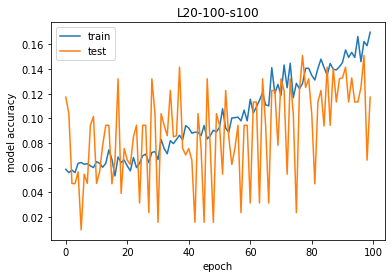

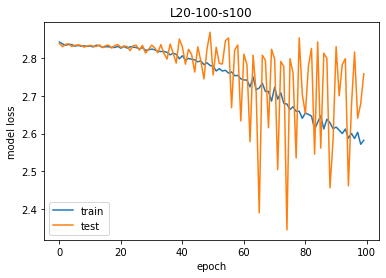

In [41]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+method+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+method+dataname+'_loss'+'.png')
#print(datapath+'/'+surname+dataname+'_loss'+'.png')

### confusion matrix

In [42]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

3/3 [==============================] - 0s 125ms/step


array([[7, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 4, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [2, 0, 2, 0, 1, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [4, 3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 4, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1],
       [4, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [4, 1, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 3, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 2, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 1, 2],
       [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0,

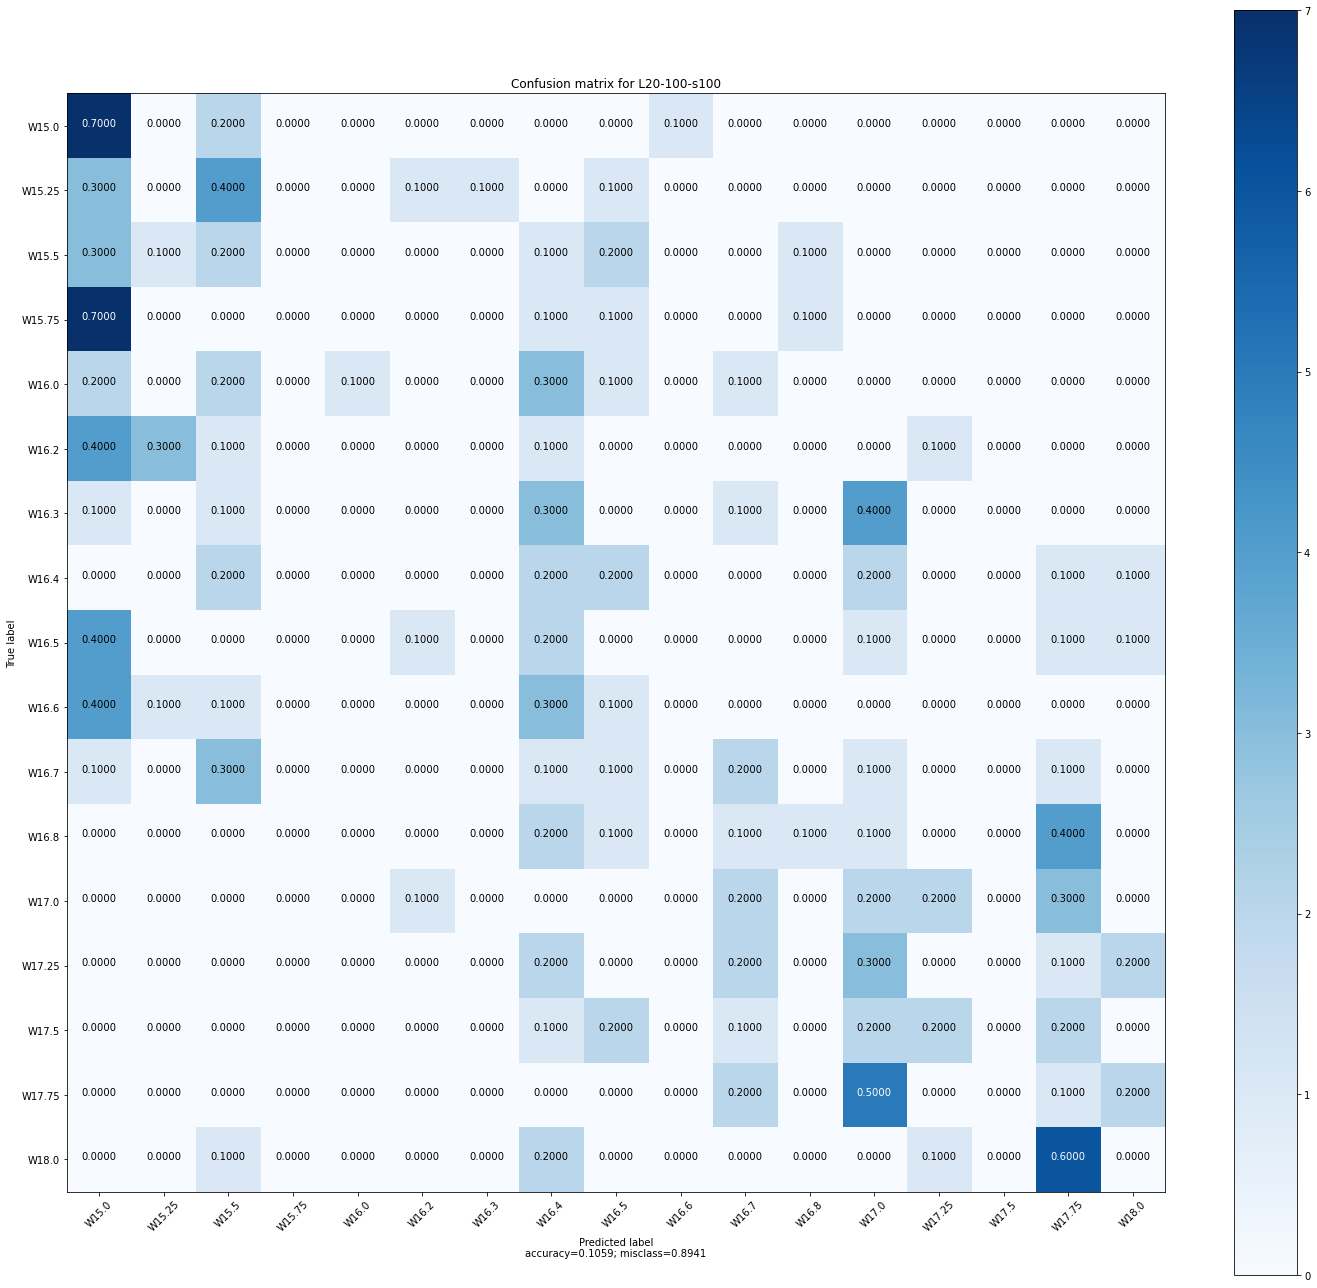

None


In [43]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')

In [ ]:
%%javascript
IPython.notebook.save_notebook()